# Demo: Universal Inverse Problem 

In this notebook, you can (1) load a pre-trained denoiser from the "denoisers" directory; (2) generate sample patches from the image prior embedded in that denoiser; and (3) use the embedded prior to solve ("regularize") any of 5 example linear inverse problems.  



In [1]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *

%matplotlib inline

# load a denoiser

Different denoisers embed different priors. In the context of deep neural networks, the learned prior depends on both the network architecture and the training dataset. Changing the architecture and/or the training set results in generated samples which are qualitatively different. 

**Using other denoisers:** You can add any other denoiser to the 'denoisers' directory and use it in our algorithm to sample from its implicit prior. Note that the denoiser has to be 
* optimized to remove additive white Gaussian noise, minimizing mean squared error,
* universal (i.e. can remove noise of any amplitude), 
* blind (i.e. operates directly on the noisy image, without explicit knowledge of the noise level). 


### 1. Denoiser architecture 

In [2]:
# Print a list of pre-trained denoiser architectures
print( os.listdir('denoisers'))

# Choose an architecture from the list
architecture = 'BF_CNN'

['BF_CNN']


### 2. Training dataset

In [3]:
# Print a list of training datasets associated with the architecture
print(os.listdir(os.path.join('denoisers',architecture)))

# Choose a trainig set:
training_data = 'BSD300_color' 

if 'color' in training_data.split('_'): 
    grayscale = False # number of input and output channels is 3
    C = 3
else: 
    grayscale = True # number of input and output channels is 1
    C = 1

['BSD300_color', 'BSD400_gray', 'mnist_gray']


In [4]:
# Now, choose the range of noise used during training from the list below
print(os.listdir(os.path.join('denoisers',architecture,training_data)))

training_noise='noise_range_0to100' 

['noise_range_0to100']


In [6]:
denoiser = load_denoiser(architecture=architecture, 
                         grayscale=grayscale, 
                         training_data=training_data, 
                         training_noise=training_noise)

denoiser.eval();

# Image synthesis

Here, we draw samples from the prior. Starting from an arbitrary point in the space of images (more specifically, an image of Gaussian noise with large variance) we use the denoiser to ascend the gradient of the implicit prior. The procedure relies on the following hyperparameters: 

* $\sigma_0$: sig_0 is the standard deviation of the noise used to generate the initial image. Default = 1 

* $h_0$: h0 is the step size, expressed as a fraction in the range $[0,1]$ of the denoising correction that is taken. Default = 0.01 

* $\beta$: beta controls the amount of noise injected in each iteration. $\beta \in (0,1] $, with smaller values indicating more noise ($\beta = 1$ indicating no noise).  Injecting noise allows the alorithm to escape local minima, changing the qualitative properties of the samples

* $\sigma_L$: sig_L is the stopping criterion. When the noise remaining in the synthesized image reaches this level (as determined by the amplitude of the denoiser correction), the algorithm terminates, returning the current image (a sample from $p_{\sigma_L}(y) \approx p(x)$).  Default = 0.01

Additionally, you can adjust the following: 
* patch_size: patch size to be generated
* freq: frequency with which intermediate samples are saved in interm_Ys (0 = don't save samples)

----------------------------- 5
sigma  0.9520106911659241
----------------------------- 10
sigma  0.8081064224243164
----------------------------- 15
sigma  0.6042243838310242
----------------------------- 20
sigma  0.40926188230514526
----------------------------- 25
sigma  0.2533872425556183
----------------------------- 30
sigma  0.1387110948562622
----------------------------- 35
sigma  0.07070644199848175
----------------------------- 40
sigma  0.03160655498504639
----------------------------- 45
sigma  0.012029311619699001
-------- total number of iterations,  47
-------- average time per iteration (s),  0.0561
value range 0.32 0.73


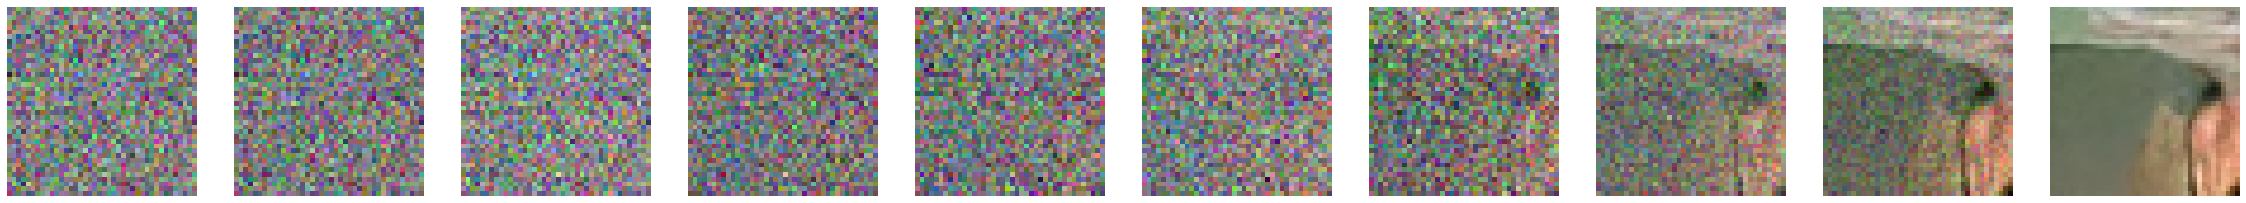

In [34]:
# choose the size of the sample patch: 
patch_size = (C,40,40) #choose 28x28 for mnist patch size
x_c = torch.zeros(patch_size) 
if torch.cuda.is_available():
    x = x.cuda()

synth = synthesis() 
sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = x_c, 
                                 task = synth,
                                 sig_0 = 1,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = 0.5,  # change beta to see how quality of generated samples change       
                                 freq = 5)

## plot the progression and the final sample
plot_synthesis(interm_Ys, sample)

# Inverse problems


Here, we use the implicit prior of the denoiser to solve linear inverse problems (i.e., recovery of an image from a partial set of linear measurements).  The same function is used to solve all problems.  In addition to the hyperparameters used in the sampling algorithm above, the linear inverse algorithm requires specification of the measurement matrix (i.e. the forward model). We provide 5 different classes: inpainting, random pixel dropping, super resolution, deblurring, and measurements on random basis (i.e. compressive sensing). You can use the algorithm for any other linear inverse problems, as long as you provide it with the forward model.

## Load a test image


In [35]:
# Choose a test dataset
# Note: grayscale/color of the test images must be consistent with grayscale/color of denoiser training data
if grayscale is True: 
    path = 'test_images/grayscale/'
else: 
    path = 'test_images/color/'
print('Test datasets: ', os.listdir(path))

test_folder = 'Set14'


Test datasets:  ['BSD100', 'Set14', 'Set5']


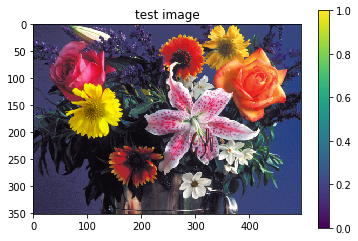

In [36]:
# choose an image number
im_num = 6

X = test_image(grayscale, path+test_folder+'/', im_num)
X.show()

torch.Size([3, 60, 60])

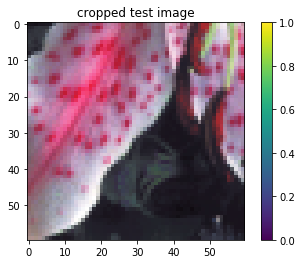

In [37]:
# crop a portion of the image (smaller will run faster)
x = X.crop(210,250,60,60)
x.shape

## 1. Inpainting



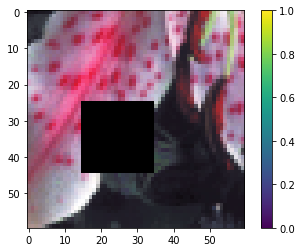

In [59]:
# Specify top-left corner and size of "hole" to be inpainted (filled in) ***
inpaint = inpainting(x_size=x.size(), y0=25, x0=35, h=20, w=20)

plot_corrupted_im(inpaint.M(inpaint.M_T(x)))


----------------------------- 40
sigma  0.9204882383346558
----------------------------- 80
sigma  0.830589771270752
----------------------------- 120
sigma  0.6504204869270325
----------------------------- 160
sigma  0.48849567770957947
----------------------------- 200
sigma  0.35764697194099426
----------------------------- 240
sigma  0.244967520236969
----------------------------- 280
sigma  0.1607016921043396
----------------------------- 320
sigma  0.09501367807388306
----------------------------- 360
sigma  0.051474589854478836
----------------------------- 400
sigma  0.01797710545361042
-------- total number of iterations,  420
-------- average time per iteration (s),  0.1195


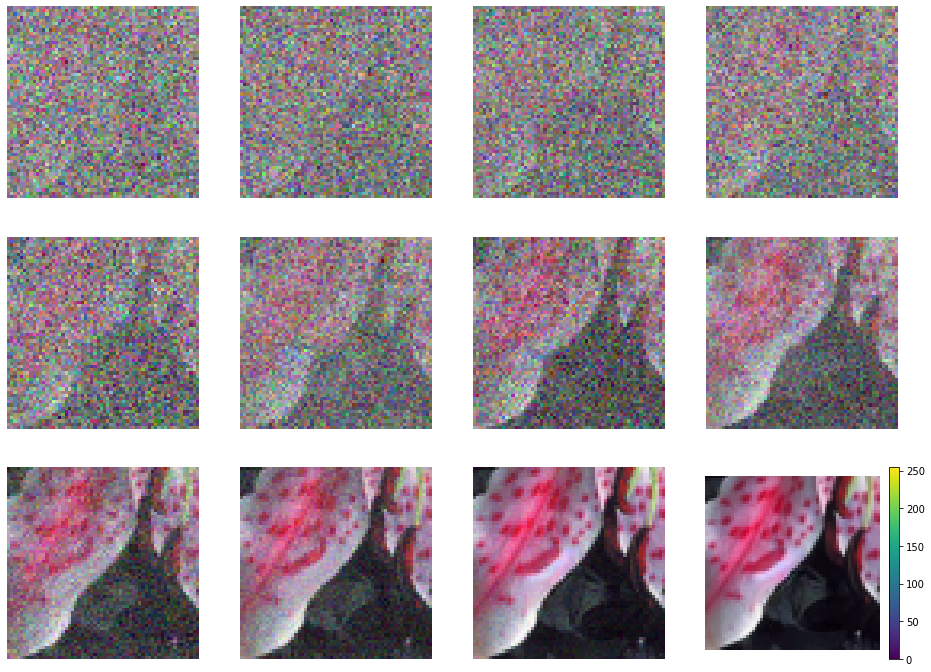

In [68]:
# In solving linear inverse problems, in order to get good quality samples, beta should be small, that is lots of 
# added noise in each iteration. 
# This gives the algorithm the freedom to explore the space and arrive at a point on the manifold where the 
# linear constraint is satisfied

sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = inpaint.M_T(x), 
                                 task = inpaint,
                                 sig_0 = 1,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = 0.01,          
                                 freq = 40)
plot_all_samples(sample, interm_Ys)

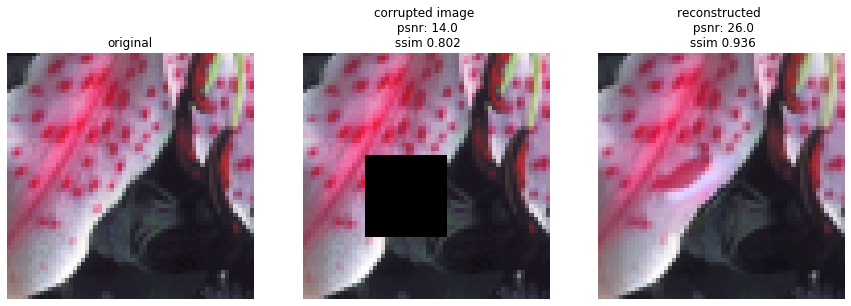

In [69]:
plot_sample(x, inpaint.M(inpaint.M_T(x)), sample)

## 2. Missing random pixels

*** Retained 2160 / 10800 (20.0%) of pixels
----------------------------- 40
sigma  0.9193487763404846
----------------------------- 80
sigma  0.7505782246589661
----------------------------- 120
sigma  0.528700590133667
----------------------------- 160
sigma  0.3084726631641388
----------------------------- 200
sigma  0.1474885493516922
----------------------------- 240
sigma  0.010347548872232437
-------- total number of iterations,  242
-------- average time per iteration (s),  0.1286


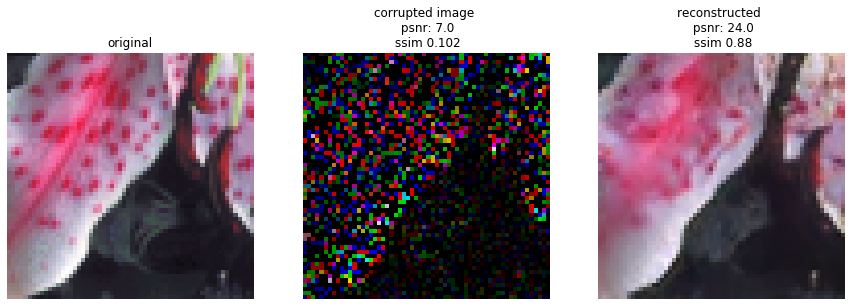

In [60]:
# Retain a random subset of pixels. 
rand_pix = rand_pixels(x_size = x.size(), p = 0.2) # p = fraction of pixels kept

print_dim(measurment_dim=rand_pix.mask.sum().item(), image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = rand_pix.M_T(x), 
                                 task = rand_pix,
                                 sig_0 = 1 ,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = 0.01,          
                                 freq = 40)

plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

## 3. Super resolution 


*** Retained 675 / 10800 (6.25%) of pixels
----------------------------- 40
sigma  0.8846310973167419
----------------------------- 80
sigma  0.6455515623092651
----------------------------- 120
sigma  0.4071239233016968
----------------------------- 160
sigma  0.20905166864395142
----------------------------- 200
sigma  0.053421907126903534
-------- total number of iterations,  215
-------- average time per iteration (s),  0.1147


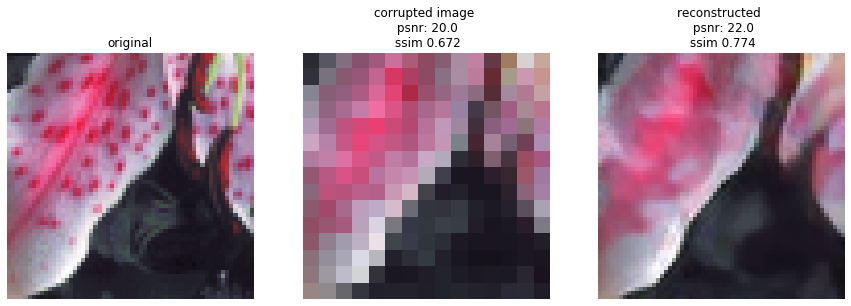

In [61]:
# Subsample image by factor of s (both horizontally and vertially)
super_res = super_resolution(x_size=x.size(), s = 4)

print_dim(measurment_dim=np.prod(super_res.M_T(x).shape), image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser, 
                                  x_c = super_res.M_T(x), 
                                  task = super_res,
                                  sig_0 = 1 ,
                                  sig_L = 0.01, 
                                  h0 = 0.01, 
                                  beta = 0.01,          
                                  freq = 40)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)

## 4. Random basis

*** Retained 2160 / 10800 (20.0%) of pixels
----------------------------- 40
sigma  0.9774008393287659
----------------------------- 80
sigma  0.7627303600311279
----------------------------- 120
sigma  0.49946358799934387
----------------------------- 160
sigma  0.2798944115638733
----------------------------- 200
sigma  0.1233203262090683
-------- total number of iterations,  238
-------- average time per iteration (s),  0.1663


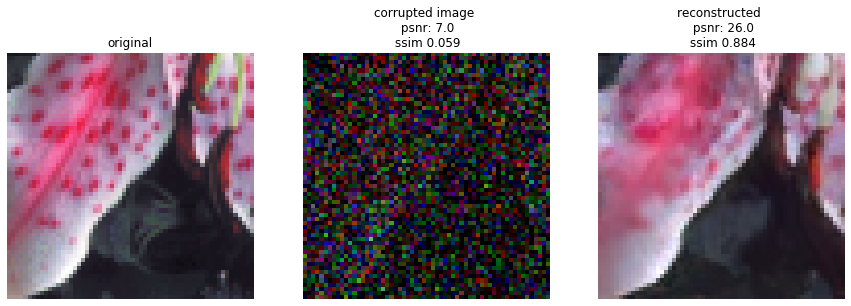

In [64]:
# Project image onto a random set of basis functions
rand_basis = random_basis(x_size = x.shape , p = 0.2) # p = fraction of dimensions kept

print_dim(measurment_dim=rand_basis.U.shape[1], image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = rand_basis.M_T(x), 
                                 task = rand_basis,
                                 sig_0 = 1,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = .01,          
                                 freq = 40)

plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

## 5. Spectral super resolution

*** Retained 2028 / 10800 (18.778%) of pixels
----------------------------- 40
sigma  0.9072555899620056
----------------------------- 80
sigma  0.7713412046432495
----------------------------- 120
sigma  0.5428550839424133
----------------------------- 160
sigma  0.36325332522392273
----------------------------- 200
sigma  0.19575245678424835
----------------------------- 240
sigma  0.03766894340515137
-------- total number of iterations,  251
-------- average time per iteration (s),  0.1218


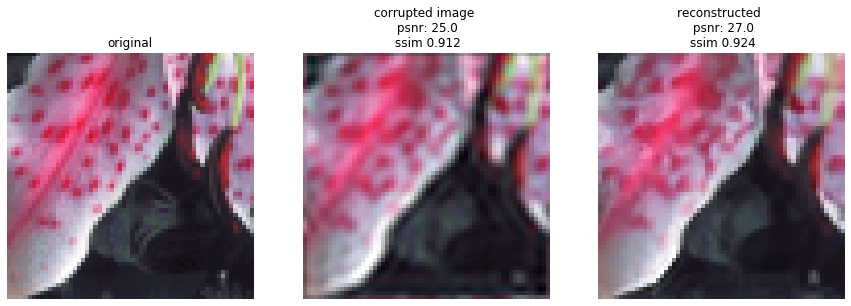

In [67]:
# Project onto low frequencies (a subset of the Fourier basis)
spec_super_res = spectral_super_resolution(x_size= x.size(), p = 0.2) # p=fraction of low frequencies kept

print_dim(measurment_dim=spec_super_res.mask.sum()*3, image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser, 
                                  x_c=spec_super_res.M_T(x), 
                                  task = spec_super_res,
                                  sig_0=1 ,
                                  sig_L=.01, 
                                  h0=.01, 
                                  beta = 0.01,          
                                  freq = 40)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)